In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [262]:
#read gdp file
df1 = pd.read_excel('gdp.xlsx')

In [263]:
#read gini file
df2 = pd.read_excel('gini.xlsx')

In [264]:
#create country list
def country():
    
    country1 = df1['country'] 
    country1 = set(country1) #gather country1

    country2 = df2['countryname']
    country2 = set(country2) #gather country2
    
    return list(country1 & country2) #find overlap

In [265]:
#select gdp data based on country name
def select1(country):
    
    df12 = df1.loc[df1['country'] == country] #select country data
    
    df12 = df12.loc[:,['year','rgdpe','pop']]#select relevant info
    df12 = df12.dropna()#drop the enpty years
    
    df12['rgdpec'] = (df12['rgdpe']/df12['pop']) #calculate gdp per capita
    
    df12 = df12.drop(['rgdpe','pop'], axis = 1)#drop the old columns
    df12.reset_index(drop = True, inplace = True)#reset index
    
    return df12

In [266]:
#select gini data based on country name
def select2(country):
    
    df22 = df2.loc[df2['countryname'] == country] #select country data
    
    df22t = df22.T#transpose so that it is in a columns format
    df22t.dropna(inplace = True)#drop empty years
    
    df22t = df22t.drop(['country','code','countryname'])#drop not useful rows
    
    df22t['year'] = df22t.index#move the year out of the index
    df22t.loc[:,'year'] = df22t['year'].astype(str).str[1:].astype(int)#change year type to be numerical
    df22t = df22t.reset_index(drop = True)#reset index
    
    df22t = df22t.rename(columns = {list(df22t.columns)[0]:'gini'})#rename column to gini
    df22t.loc[:,'gini'] = df22t['gini'].astype(float)#convert to numerical
    
    return df22t

In [267]:
#find the matching year ranges
def ranges(df12,df22):
    
    range1 = [min(df12['year']),max(df12['year'])]#find the min and max of gdp
    range2 = [min(df22['year']),max(df22['year'])]#find the min and max of gini
    range3 = [max(range1[0],range2[0]),min(range1[1],range2[1])]#find the start and end of the range
    
    return range(range3[0],range3[1]+1)#return a range

In [268]:
#merge the two dataframes based on the year
def merges(df12,df22,frange):
    
    df31 = pd.DataFrame(index = frange, columns = ['gdp','gini'])#initialise the dataframe
    
    for i in frange:#for each year
        
        df31.loc[i,'gdp'] = float(df12.loc[df12['year'] == i, 'rgdpec'])#select that gdp
        
        x = df22.loc[df22['year'] == i, 'gini']#select that gini
        if len(x) != 0:#if it is not empty
            
            df31.loc[i,'gini'] = float(x)#store the gini
    
    df31.loc[:,'gdp'] = pd.to_numeric(df31['gdp'])
    df31.loc[:,'gini'] = pd.to_numeric(df31['gini'])
    
    e = df31['gini'].isnull().sum()
    
    #if the gini is half or less empty skip it
    if e > len(df31['gdp'])*0.3 and len(df31['gdp'])-e > 3: #and more than 3 gini points
        
        df31.loc[:,'gini'] = df31['gini'].interpolate()
        
    else:
        
        return -1
    
    return df31

In [269]:
#calculate the correlations
def corr(countries):
    
    #collections
    corrs = []
    country2 = []
    gdp = []
    gini = []
    
    for i in countries:
        
        #select the data
        df12 = select1(i)
        df22 = select2(i)
        
        #find overlapping timeline
        frange = ranges(df12,df22)
        
        #merge the two datasets
        df31 = merges(df12,df22,frange)
        
        #if enough gini data:
        if type(df31) != int:
            
            #calculate percent changes
            df31['%gdp'] = df31['gdp'].pct_change()
            df31['%gini'] = df31['gini'].pct_change()
            
            #start
            start = list(frange)[1]
            
            corrs.append(df31.loc[start:,'%gdp'].corr(df31.loc[start:,'%gini'],method = 'pearson'))#calculate correlation
            
            gdp.append(df31['gdp'].mean())#store the gdp
            gini.append(df31['gini'].mean())#store the gini
            
            #store successful correlation
            country2.append(i)
            
            #trouble shoot
            print(i,len(frange),start)
            #print(df31)
        
    return corrs,country2,gdp,gini

In [270]:
#main

#replace faulty spelling
df1 = df1.replace(['Iran (Islamic Republic of)',"Côte d'Ivoire",'Myanmar','United States','Venezuela (Bolivarian Republic of)', 'Viet Nam'],['Iran','Ivory Coast','Myanmar (Burma)', 'United States of America', 'Venezuela', 'Vietnam'])

#running the country overlap finder
countries = country()

#sorting the countries alphabetically
countries = sorted(list(country()))

#running sub program
corrs,country2,gdp,gini = corr(countries)

#re-adjusting countries
countries = country2
corrs

Angola 24 1971
Armenia 21 1995
Burundi 43 1972
China 34 1978
Congo 21 1969
Costa Rica 41 1964
Gabon 30 1967
Iceland 27 1971
Ivory Coast 32 1967
Jamaica 42 1964
Lesotho 28 1983
Mozambique 34 1968
Nepal 23 1987
Romania 53 1964
Rwanda 18 1970
Saudi Arabia 14 1997
Sri Lanka 49 1967
Thailand 39 1969
Tunisia 52 1964
Uganda 38 1964
United Arab Emirates 9 1978
Vietnam 17 1999
Zambia 32 1964


[-0.3767359949575082,
 0.11936476981722809,
 -0.1915992758095489,
 -0.14360414422659787,
 -0.4365970909681805,
 -0.14659526465736866,
 -0.05437937888802234,
 0.28211802935980523,
 -0.11239960637693194,
 0.04381813548635227,
 -0.2171051795210892,
 0.14756325704923295,
 -0.6087408713037807,
 -0.381948406061946,
 0.09535273044977212,
 -0.5292456961096372,
 0.11204774554629317,
 -0.21374963632755137,
 -0.065109949850135,
 -0.08118662467547301,
 -0.5540318752957741,
 0.16247584762643366,
 -0.4412287918146889]

# Visualisation

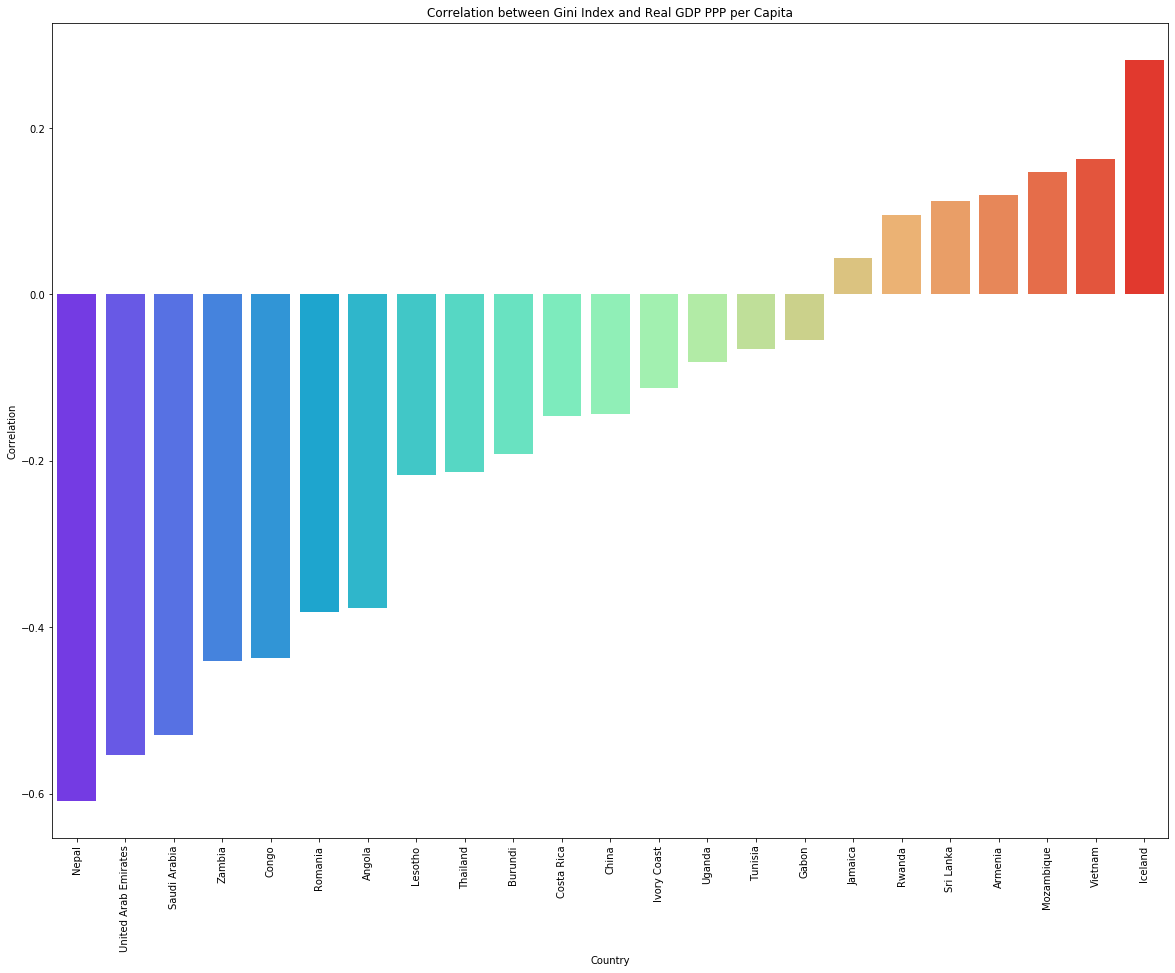

-0.15615292484822244

In [271]:
df4 = pd.DataFrame()
df4['country'] = countries
df4['cor'] = corrs
df4 = df4.sort_values(by=['cor'])

fig,ax = plt.subplots(figsize = (20,15))
sns.barplot(x = 'country',y ='cor', data = df4, palette = 'rainbow').set_title('Correlation between Gini Index and Real GDP PPP per Capita')
plt.ylabel('Correlation')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()
df4['cor'].mean()

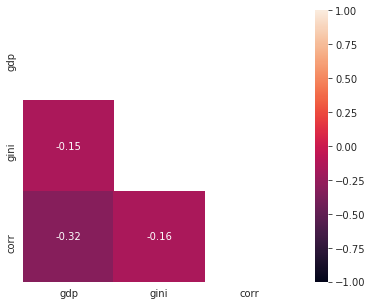

In [272]:
df42 = pd.DataFrame()
df42['gdp'] = gdp
df42['gini'] = gini
df42['corr'] = corrs

corr = df42.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, annot = True,vmin = -1,vmax = 1, square = True)


In [289]:
from bokeh.plotting import figure, output_file, show 
        
# file to save the model 
output_file("gfg.html") 
        
# instantiating the figure object 
graph = figure(title = "Inequality and GDP estimation") 
      
graph.xaxis.axis_label = "GDP"
       
# name of the y-axis  
graph.yaxis.axis_label = "Inequality"

# the points to be plotted 
x0 = 0
y0 = 0
x1 = 1
y1 = 0
cx = 0.5
cy = 2
  
# plotting the graph 
graph.quadratic(x0, y0, 
                x1, y1, 
                cx, cy) 
      
# displaying the model 
show(graph) 